In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib
from scipy.ndimage import gaussian_filter1d
import os
from lmfit import Model

import get_model

In [2]:
# this cell will not work if you have python < 3.8
# it is not necessary to run the rest of the notebook
from importlib.metadata import version
print('nump',version('numpy'))
print('pandas',version('pandas'))
print('scipy',version('scipy'))
print('matplotlib',version('matplotlib'))
print('lmfit',version('lmfit'))

nump 1.20.3
pandas 1.1.3
scipy 1.5.0
matplotlib 3.3.2
lmfit 1.0.1


In [3]:
path = os.getcwd()
co_path = '/'.join(path.split('/')[:-1])+'/'
plot = 0
coplus = 0
co_path

'/Users/sfdavis/CO-modeling/'

In [4]:
redshift  = 0.001826
list_of_spectra = [co_path+'example/SN2016adj_20160521_BAA_NIR.txtdered.fits.txt']

phase = np.array([530.60])-431.3#since b max
d = 3.42 # pm 0.18 Mpc
d = d * 3.08567758128E+24
print('Distance in cm:',d)

Distance in cm: 1.05530173279776e+25


In [18]:
num = 0
spec = list_of_spectra[num]
specPhase = phase[num]

spec=pd.read_csv(spec,delimiter='\s+',header=None)
    
if spec.shape[1] == 2:
    spec.columns = ['lambda','flux']  
if spec.shape[1] == 3:   
    spec.columns = ['lambda','flux','err']
if spec['lambda'].values[10] > 1000:
    spec['lambda'] = spec['lambda']/1e4
spec['lambda'] = spec['lambda']/(1+redshift)
spec = spec[(spec['lambda']>2.2)]

# wavelength needs to be in microns for the intergration
upper, lower = 2.28, 2.45
w = np.argmin(abs(np.array(spec['lambda'])-upper))
v = np.argmin(abs(np.array(spec['lambda'])-lower))
fluxinteg = np.trapz(spec['flux'][w:v],spec['lambda'][w:v]*1.0e4)
luminosity = fluxinteg*4*np.pi*(d**2)
print('Flux integrated over '+str(upper)+'-'+str(lower)+' micron:',fluxinteg,'ergs/s/cm^2')
print('Luminosity over the same region: ',luminosity,'ergs/s')


# data scaling
upper, lower = 2.20, 2.25
if coplus: upper, lower = 2.20, 2.25
w = np.argmin(abs(np.array(spec['lambda'])-upper))
v = np.argmin(abs(np.array(spec['lambda'])-lower))
integ0 = np.trapz(spec['flux'][w:v],spec['lambda'][w:v])
off = 0.05/integ0
q = [(spec['lambda'] >= 2.25) & (spec['lambda'] <= 2.3)][0]
spec['flux'] = np.array(spec['flux'])*off
shift = np.min(spec['flux'][q])
spec['flux'] = spec['flux'] - shift
spec = spec[(spec['flux'] > 0)]
specSmooth = gaussian_filter1d(spec['flux'],40)

Flux integrated over 2.28-2.45 micron: 3.1622706448967573e-12 ergs/s/cm^2
Luminosity over the same region:  4.425498552849724e+39 ergs/s


# Find best fitting models

In [19]:
df = pd.read_csv(co_path+'Hoeflich_models.csv')

# Limiting to only the models that we care about for this example, i.e. what will fit reasonably well.
df = df[(df.molecule == 'CO')]
df = df[(df.mole_frac==0.1)] 
df

,filename,dataset,mole_frac,temperature,density,velocity,molecule
64,plot.dat_5000_3_0.1_CO,3,0.1,5000.0,1.000000e+07,5000,CO
65,plot.dat_5000_3_0.1_CO,3,0.1,5000.0,1.000000e+08,5000,CO
66,plot.dat_5000_3_0.1_CO,3,0.1,5000.0,1.000000e+09,5000,CO
67,plot.dat_5000_3_0.1_CO,3,0.1,5000.0,1.000000e+11,5000,CO
68,plot.dat_5000_3_0.1_CO,3,0.1,4000.0,1.000000e+07,5000,CO
...,...,...,...,...,...,...,...
2587,plot.dat_2000_3_0.1_CO,3,0.1,1750.0,1.000000e+11,2000,CO
2588,plot.dat_2000_3_0.1_CO,3,0.1,1500.0,1.000000e+07,2000,CO
2589,plot.dat_2000_3_0.1_CO,3,0.1,1500.0,1.000000e+08,2000,CO
2590,plot.dat_2000_3_0.1_CO,3,0.1,1500.0,1.000000e+09,2000,CO


16.4% done.
32.9% done.
49.3% done.
65.8% done.
82.2% done.
98.7% done.


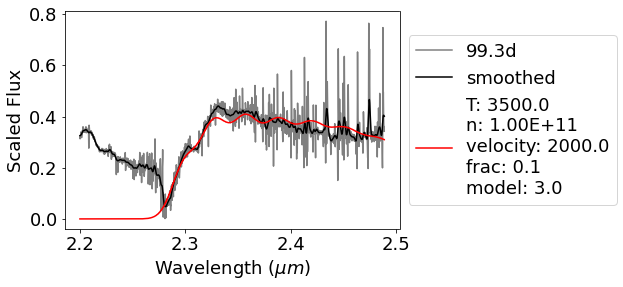

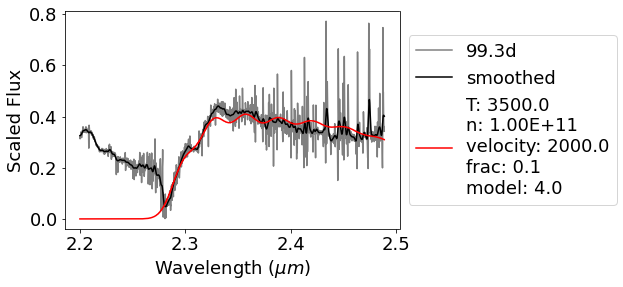

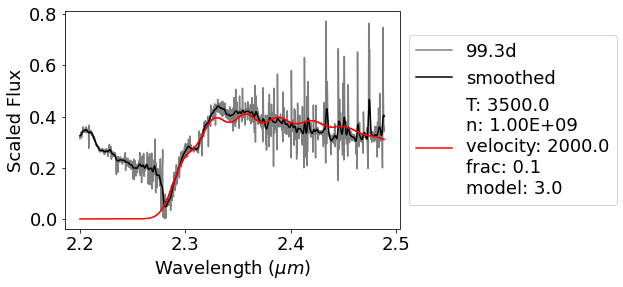

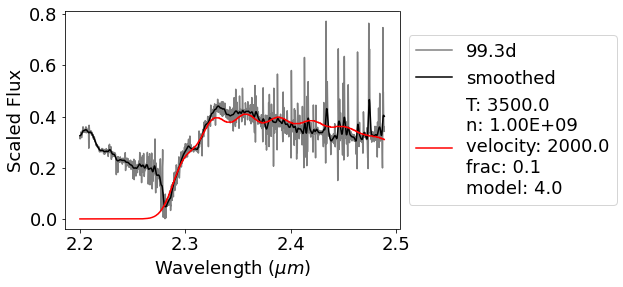

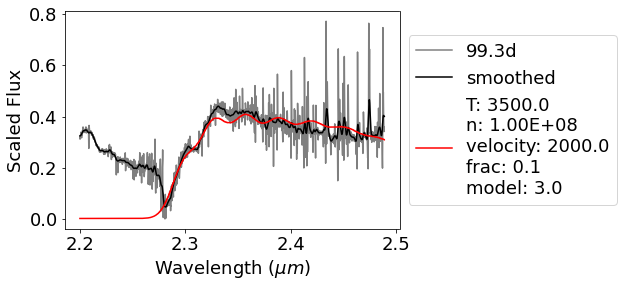

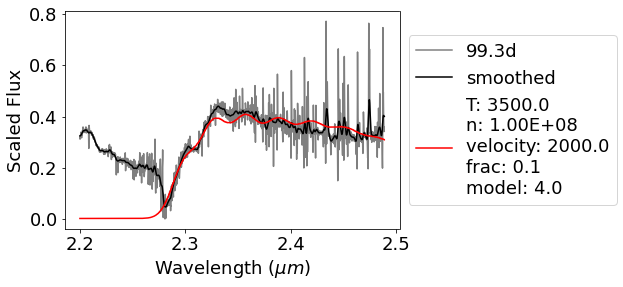

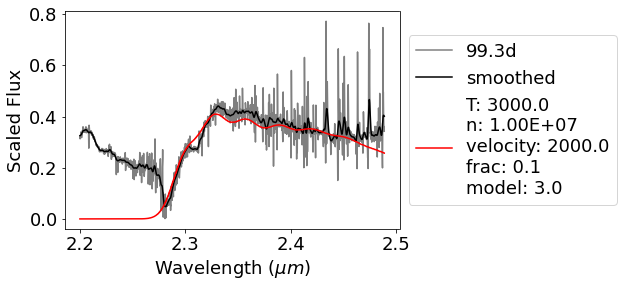

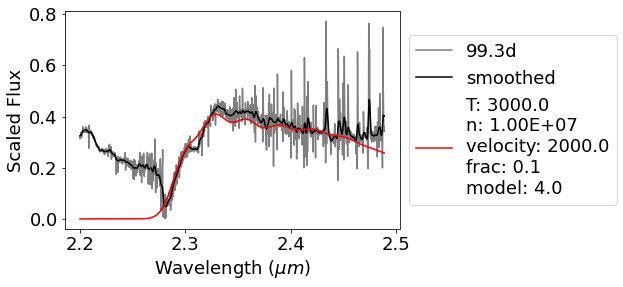

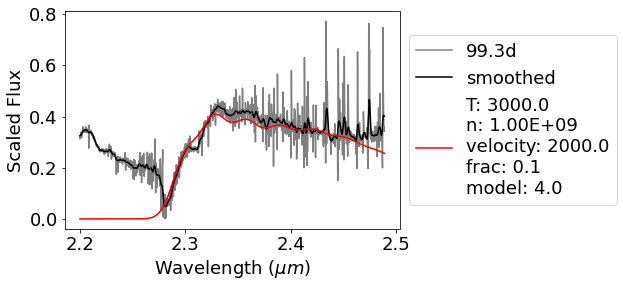

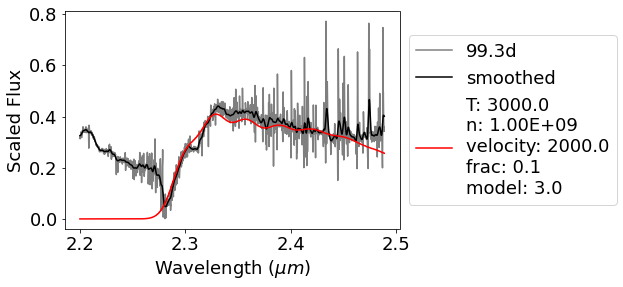

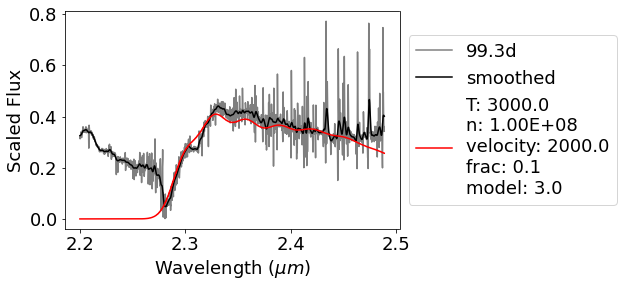

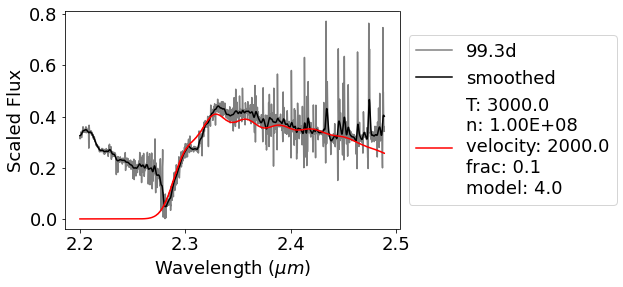

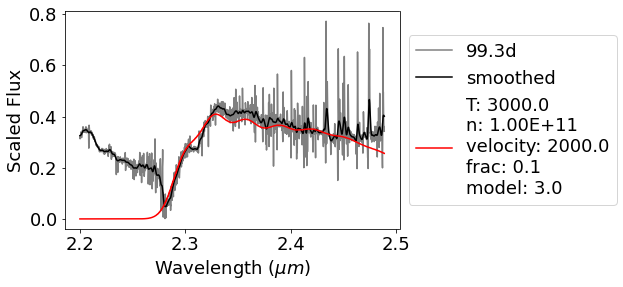

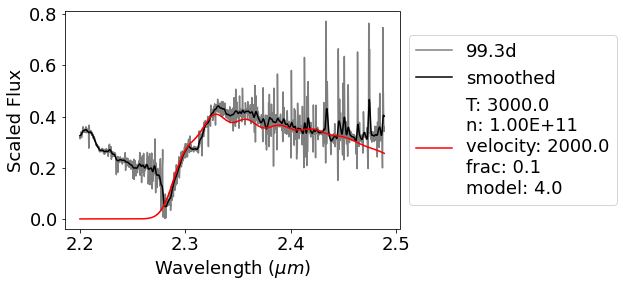

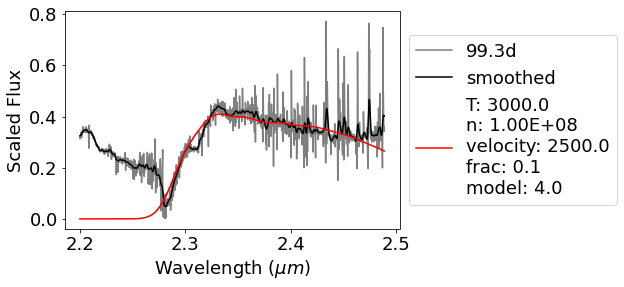

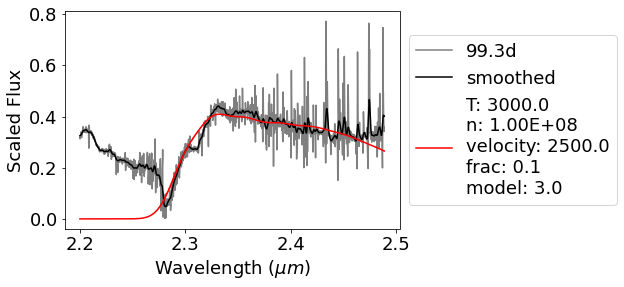

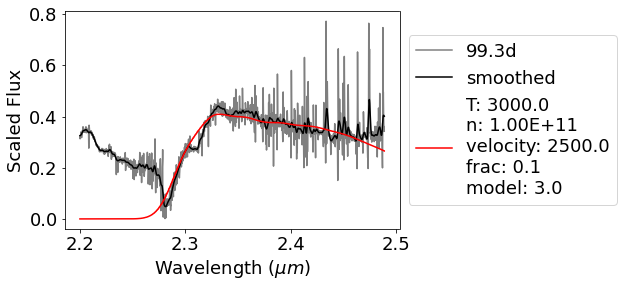

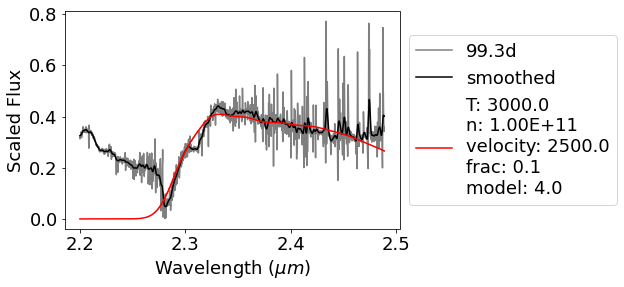

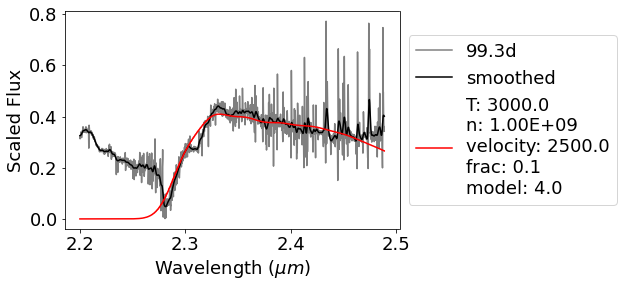

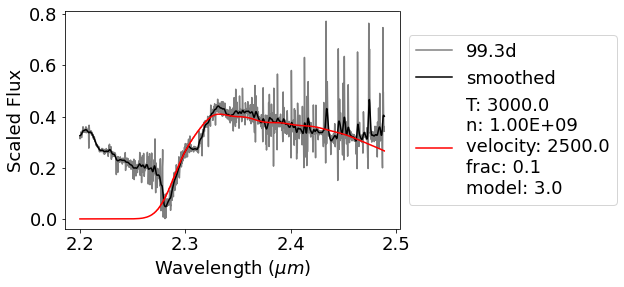

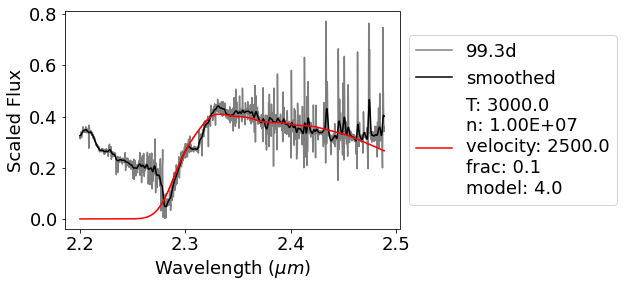

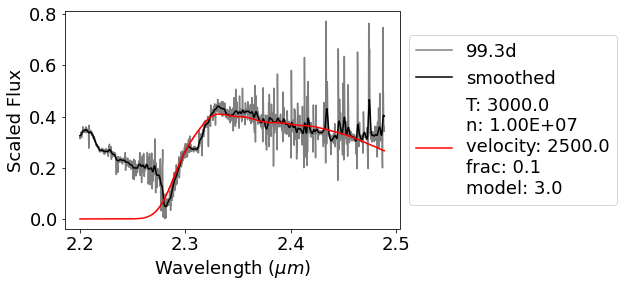

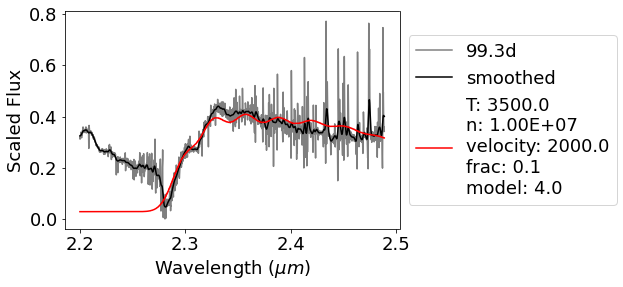

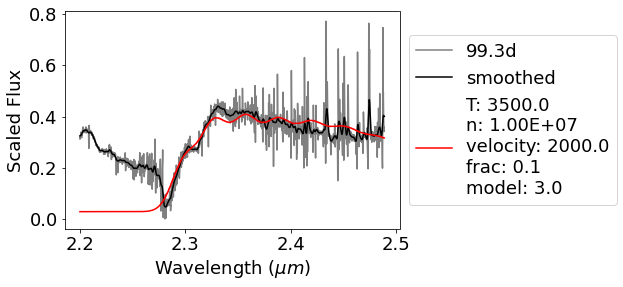

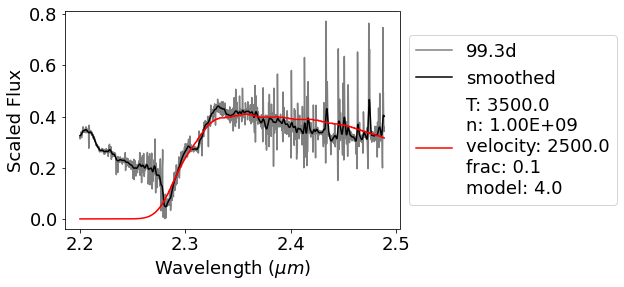

In [20]:
# this just supresses all the warnings that numpy and python like to throw
import warnings
warnings.filterwarnings("ignore")

def get_model_new(path,temp,dens,velocity,mole_frac,molecule,modelset):
    modeldf = pd.read_csv(co_path+'/models_csv/'+
                          molecule+'_'+str(modelset)+'_'+str(velocity)+'_'+str(mole_frac)+'.csv')

    dens = str(format(dens, "10.2E")).strip()
    temp = str(format(temp, ".2f")).strip()

    return [modeldf['wl'].values, modeldf[dens+'/'+temp].values]

# loop over models
chisq, fArr, fileArr, params = [], [], [], []
for i in range(len(df)):
    if i%100 == 0 and i != 0: 
        print(str(round(i/len(df)*100,1))+'% done.')
        
    # get model from csv file
    wav, opac = get_model.get_csv(co_path+'/models_csv/',df.temperature.values[i],
                                  df.density.values[i],df.velocity.values[i],
                                  df.mole_frac.values[i],df.molecule.values[i],df.dataset.values[i])
    wav = wav/1e4
    
    # trim model
    w = np.where(wav >= 2.2)
    wav, opac = np.array(wav[w]), np.array(opac[w])
    
    # model scaling
    w = np.argmin(abs(wav-upper))
    v = np.argmin(abs(wav-lower))
    q = [(spec['lambda'] >= 2.25) & (spec['lambda'] <= 2.3)][0]
    integ = np.min(spec['flux'][q]) + np.trapz(opac[w:v],wav[w:v])
    opac = opac + integ
    interpF = np.interp(spec['lambda'],wav,opac) # interpolating to same x
    # scaling the model to match the data since the amount of CO is a free parameter
    w = [(spec['lambda'] >= 2.34)&(spec['lambda'] <= 2.35)][0]
    interpF = interpF*np.median(spec['flux'][w])/np.max(interpF)
    
    if plot:
        plt.plot(spec['lambda'],spec['flux'],color='black')
        plt.plot(spec['lambda'],interpF,color='red')
        plt.show()
        
    w = [(spec['lambda'] >= 2.28) & (spec['lambda'] <= 2.46)][0]
    #chisq.append(stats.chisquare(interpF[w],spec['flux'].values[w])[0])
    chisq.append(stats.chisquare(interpF[w],specSmooth[w])[0])
    fArr.append(interpF)
    fileArr.append(i)
    params.append([df.temperature.values[i],df.density.values[i],df.velocity.values[i],
                   df.mole_frac.values[i],df.dataset.values[i]])
    
w = np.argsort(chisq)
chisq, fArr, fileArr, params = np.array(chisq)[w], np.array(fArr)[w], np.array(fileArr)[w], np.array(params)[w]

# plot best XX models for each spectrum
matplotlib.rcParams.update({'font.size': 18})
for i in range(25):
    label = r'T: '+str(params[i][0])+'\n'+'n: '+format(params[i][1],".2E")+'\n'+\
             'velocity: '+str(params[i][2])+'\n'+'frac: '+str(params[i][3])+'\n'+'model: '+str(params[i][4])
    
    w = [(spec['lambda'].values < 2.5)]
    plt.plot(spec['lambda'].values[w],spec['flux'].values[w],color='black',alpha=0.5)
    plt.plot(spec['lambda'].values[w],specSmooth[w],color='black')
    plt.plot(spec['lambda'].values[w],fArr[i][w],color='red',label=label)
    
    q = [(spec['lambda'].values > 2.2) & (spec['lambda'].values < 2.5)]
    plt.xlabel(r'Wavelength ($\mu m$)')
    plt.ylabel('Scaled Flux')
    plt.legend(bbox_to_anchor=(1.0,0.5), loc="center left",labels=[str(round(specPhase,1))+'d','smoothed',label])

    plt.show()

# Now we get the best fitting model(s) and get a lower limit for the CO temperature. This assumes that the flux is given as F_lambda

Continuum integrated over 22800.0-24500.0 angstroms: 2.216E-12 ergs/s/cm^2
Flux integrated over 22800.0-24500.0 angstroms: 3.162E-12 ergs/s/cm^2
Difference in integrations 9.462E-13 ergs/s/cm^2
Luminosity over the same region:  1.324E+39 ergs/s
eta: 4.120E+08
Mass: 3.214E+30 g
Mass: 1.616E-03 Msun


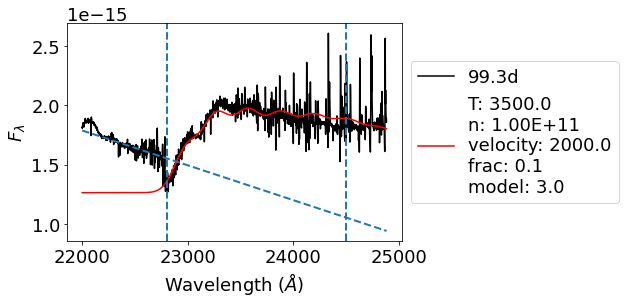

In [21]:
def B_lambda(T,x):
    h = 6.6261e-27 #* (1e8**2)
    k = 1.3807e-16 #* (1e8**2)
    c = 2.998e10 #* (1e8)

    top = 2*h*(c**2) / x**5
    bottom = np.exp(h*c / (x*k*T)) - 1.0
    return top/bottom

def line(x,m,b):
    return m*x + b

w = [(spec['lambda'].values < 2.5)]
x = spec['lambda'].values[w]*1.0e4
specy = (spec['flux'].values[w] + shift) / off

# continuum integration and extrapolation
clower, cupper = 2.22*1e4,2.27*1e4
w = np.argmin(abs(np.array(x)-clower))
v = np.argmin(abs(np.array(x)-cupper))
# fitting continuum
gmodel = Model(line)
parameters = gmodel.make_params(m=-0.5,b=0.0)
fit = gmodel.fit(specy[w:v], parameters, x=x[w:v])
# line is shifted to match the minimum of the flux, maybe not necessary 
liney = line(x,fit.params['m'],fit.params['b'])# + (min(specy) - y[np.argmin(specy)])

# do math for flux calibrated spectrum, given as F_lambda
lower, upper = 2.28*1e4, 2.45*1e4
w = np.argmin(abs(np.array(x)-lower))
v = np.argmin(abs(np.array(x)-upper))
fluxinteg = np.trapz(specy[w:v],x[w:v])

# integrate continuum over the same region, get the difference, and then luminosity
continuuminteg = np.trapz(liney[w:v],x[w:v])
luminosity = (fluxinteg-continuuminteg)*4*np.pi*(d**2)

print('Continuum integrated over '+str(round(lower,0))+'-'+str(round(upper,0))+' angstroms:',
      format(continuuminteg,".3E"),'ergs/s/cm^2')
print('Flux integrated over '+str(round(lower,0))+'-'+str(round(upper,0))+' angstroms:',
      format(fluxinteg,".3E"),'ergs/s/cm^2')
print('Difference in integrations',
      format(fluxinteg-continuuminteg,".3E"),'ergs/s/cm^2')
print('Luminosity over the same region: ',format(luminosity,".3E"),'ergs/s')

for i in range(1):
    # plot match again, but in absolute flux, just for a sanity check
    w = [(spec['lambda'].values < 2.5)]
    modely = (fArr[i][w] + shift) / off
    plt.plot(x,specy,color='black')
    y = line(x,fit.params['m'],fit.params['b'])
    plt.plot(x,modely,color='red')
    # plotting integration region as well
    plt.axvline(upper,linestyle='--',linewidth=2)
    plt.axvline(lower,linestyle='--',linewidth=2)
    plt.plot(x,liney,linestyle='--',linewidth=2)
    
    
    # get original model to integrate over
    wav, opac = get_model.get_csv(co_path+'/models_csv/',params[i][0],params[i][1],int(params[i][2]),
                              params[i][3],'CO',int(params[i][4]))
    
    # do math for model opacity
    w = np.argmin(abs(np.array(wav)-lower))
    v = np.argmin(abs(np.array(wav)-upper))
    blackbody = B_lambda(params[i][0],wav*1e-8)
    modelinteg = np.trapz((opac[w:v])*blackbody[w:v],wav[w:v]*1e-8)
    print('eta:',format(modelinteg,".3E"))
    print('Mass:',format(luminosity/modelinteg,".3E"),'g')
    print('Mass:',format(luminosity/modelinteg/1.989e+33,".3E"),'Msun')
    
    label = r'T: '+str(params[i][0])+'\n'+'n: '+format(params[i][1],".2E")+'\n'+\
             'velocity: '+str(params[i][2])+'\n'+'frac: '+str(params[i][3])+'\n'+'model: '+str(params[i][4])
    q = [(spec['lambda'].values > 2.2*1e4) & (spec['lambda'].values < 2.5*1e4)]
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel(r'$F_\lambda$')
    
    plt.legend(bbox_to_anchor=(1.0,0.5), loc="center left",labels=[str(round(specPhase,1))+'d',label])
    plt.show()